In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import multibind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd

bd.constants.ANNOTATIONS_DIRECTORY = '/home/johanna/ICB/annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker


# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cpu


In [3]:
data = bd.bindome.datasets.SELEX.get_data()
# data[data['cycle'] == 'AF']
data

PRJEB3289
# filenames 68
PRJEB14744
# filenames 12
PRJEB9797
# filenames 184
PRJEB20112
# filenames 46


,filename,library,batch,cycle,tf.name,accession
0,ETS1_TGTACC30NCAG_AI_2.fastq.gz,TGTACC30NCAG,AI,2,ETS1,PRJEB3289
1,ELK1_TGAGTG20NTGA_AG_1.fastq.gz,TGAGTG20NTGA,AG,1,ELK1,PRJEB3289
2,ZeroCycle_TGAGTG20NTGA_0_0.fastq.gz,TGAGTG20NTGA,0,0,ZEROCYCLE,PRJEB3289
3,ELK1_TAGCAG30NACT_AI_2.fastq.gz,TAGCAG30NACT,AI,2,ELK1,PRJEB3289
4,ZeroCycle_TCCGTG20NTGC_0_0.fastq.gz,TCCGTG20NTGC,0,0,ZEROCYCLE,PRJEB3289
...,...,...,...,...,...,...
305,ZeroCycle_TACATC40NATA_0_0.fastq.gz,TACATC40NATA,0,0,ZEROCYCLE,PRJEB20112
306,ZeroCycle_TATACC40NGCC_0_0.fastq.gz,TATACC40NGCC,0,0,ZEROCYCLE,PRJEB20112
307,ZeroCycle_TGGTAC40NTCT_0_0.fastq.gz,TGGTAC40NTCT,0,0,ZEROCYCLE,PRJEB20112
308,ZeroCycle_TAGGAG40NAGT_0_0.fastq.gz,TAGGAG40NAGT,0,0,ZEROCYCLE,PRJEB20112


In [4]:
set(data['tf.name'])

{'ALX1',
 'ALX4',
 'EGR1',
 'ELF2',
 'ELF3',
 'ELF4',
 'ELK1',
 'ELK3',
 'ETS1',
 'ETV4',
 'ETV5',
 'ETV6',
 'FOXA1',
 'ZEROCYCLE'}

### Custom optimization pipeline: one layer is flexible and the others are frozen.

Only one unfrozen layer, test with ALX4

In [6]:
# %time np.array([mb.tl.onehot_mononuc(row['seq'], le, oe) for index, row in next_data.head(10000).iterrows()]).shape

In [7]:
# %time next_data.head(10000)['seq'].apply(mb.tl.onehot_mononuc, args=(le, oe)) # (row['seq'], le, oe) for index, row in next_data.head(10).iterrows()])

In [6]:
model_by_k = {}
for tf in set(data['tf.name']):
    if 'ZERO' in tf:
        continue
    if tf != 'ALX4':
        continue
    print(tf)


    for library, grp in data.groupby('library'):

        if library != 'TGTGTC20NGA':
            continue

        data_sel_tf = grp[(grp['tf.name'] == tf)] #  & (grp['cycle'].astype(str) == '1')]
        data_sel_zero = grp[(grp['cycle'] == 0) & grp['library'].isin(set(grp[grp['tf.name'] == tf]['library']))]  # & grp['accession'].isin(set(grp[grp['tf.name'] == tf]['accession']))]

        print(data_sel_tf.shape[0], data_sel_zero.shape[0])
        if data_sel_tf.shape[0] == 0 or data_sel_zero.shape[0] == 0:
            continue

        print('loading', tf, ':', library)
        reads_tf = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_tf)
        reads_zero = mb.bindome.datasets.SELEX.load_read_counts(data=data_sel_zero, library=library)

        print(reads_tf.keys(), reads_zero.keys())

        for k_r0 in reads_zero:

            # k_model = tf + ':' + k_r0
            # print(k_r0, k_tf, k_model)

            n_rounds = len(reads_tf.keys())
            print(n_rounds)

            # combine all the positive round data
            df2 = []
            for k in reads_tf.keys():
                df = reads_tf[k]
                df['k'] = k
                df2.append(df)
            df = pd.concat(df2)
            df = df.pivot('seq', 'k', 'counts').fillna(0).reset_index()

            next_data = reads_zero[k_r0].merge(df, on='seq', how='outer').fillna(0) # .astype(int)

            new_cols = ['seq', k_r0] + list(df.columns[1:])
            next_data.columns = new_cols
            for i, k in enumerate(next_data.columns[1:]):
                next_data[k] = next_data[k].astype(int)
                next_data[i] = next_data[k].astype(int)


            next_data['sum'] = next_data[[i for i in range(0, n_rounds + 1)]].sum(axis=1).values
            next_data = next_data.sort_values('sum', ascending=False)

            print('sampling from top n reds in round 1 ...')
            print(next_data.shape)
            next_data = next_data.head(40000).reset_index(drop=True)
            print(next_data.shape)

            # assert False

            # next_data = next_data.sample(n=35000)

            # print(next_data.shape)
            # print(next_data.head())

            # not needed for the current model, because the enrichment is not predicted
            # next_data = mb.tl.calculate_enrichment(next_data, cols=next_data.columns[1:])

            # assign batch and data type
            next_data['batch'] = 1
            next_data['is_count_data'] = 1

            print('loading object (# entries)', next_data.shape[0])
            dataset = mb.datasets.SelexDataset(next_data, n_rounds=n_rounds)
            train = tdata.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
            train_test = tdata.DataLoader(dataset=dataset, batch_size=1, shuffle=False)

            print('done...')
            assert False
            ### steps to train model
            model = mb.models.DinucSelex(use_dinuc=True, kernels=[0, 14, 8],  n_rounds=4).to(device)
            optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
            criterion = mb.tl.PoissonLoss()

            mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=200, early_stopping=20, log_each=10)

            # probably here load the state of the best epoch and save
            model.load_state_dict(model.best_model_state)

            # store model parameters and fit for later visualization
            model_by_k[k_model] = model

            assert False

                # stop (debugging)


ALX4
4 2
loading ALX4 : TGTGTC20NGA
# uniq reads/total counts 101449/111238
# uniq reads/total counts 190669/192252
# uniq reads/total counts 166433/166744
# uniq reads/total counts 276697/298358
# uniq reads/total counts 10303/10356
# uniq reads/total counts 218392/218540
dict_keys(['ALX4_TGTGTC20NGA_W_4', 'ALX4_TGTGTC20NGA_W_2', 'ALX4_TGTGTC20NGA_W_1', 'ALX4_TGTGTC20NGA_W_3']) dict_keys(['ZeroCycle_TGTGTC20NGA_0_0', 'ZeroCycle_ES0_TGTGTC20NGA_0'])
4
sampling from top n reds in round 1 ...
(712267, 12)
(40000, 12)
loading object (# entries) 40000
done...


AssertionError: 

In [7]:
next_data

,seq,ZeroCycle_TGTGTC20NGA_0_0,ALX4_TGTGTC20NGA_W_1,ALX4_TGTGTC20NGA_W_2,ALX4_TGTGTC20NGA_W_3,ALX4_TGTGTC20NGA_W_4,0,1,2,3,4,sum,batch,is_count_data
0,TCGTATGCCGTCTTCTGCTT,5,33,10,7,2,5,33,10,7,2,57,1,1
1,TTAATTAGATTAACGCACTT,0,0,1,6,10,0,0,1,6,10,17,1,1
2,ATAATCTAATTAACGCCAAC,0,0,1,2,6,0,0,1,2,6,9,1,1
3,ATCACGCTAATCTAATTAAC,0,0,0,2,7,0,0,0,2,7,9,1,1
4,ATAATCTAATTACGCACCCC,0,0,0,3,6,0,0,0,3,6,9,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,TAACTCAATTAGGTCACTAT,0,0,0,1,1,0,0,0,1,1,2,1,1
39996,ACTATAATCACATTATCTCC,0,0,0,2,0,0,0,0,2,0,2,1,1
39997,TAACTCAATTAGAGCAACAC,0,0,0,2,0,0,0,0,2,0,2,1,1
39998,ACTATAATCAAATTACTACC,0,0,0,1,1,0,0,0,1,1,2,1,1


In [10]:
def update_grad(model, position, value):
    if model.conv_mono[position] is not None:
        model.conv_mono[position].weight.requires_grad = value
    if model.conv_di[position] is not None:
        model.conv_di[position].weight.requires_grad = value
    model.log_activities[position].requires_grad = value
    if not value and model.kernels[position] is not 0:
        model.conv_mono[position].weight.grad = None
        model.conv_di[position].weight.grad = None
        model.log_activities[position].grad = None

0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


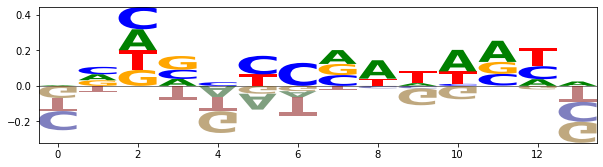

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


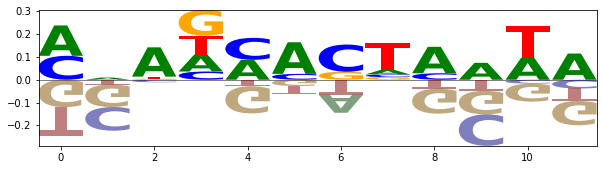

Parameter containing:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], requires_grad=True)
Epoch:  1, Loss: 1.102
Epoch: 11, Loss: 0.530
Epoch: 21, Loss: 0.529
Epoch: 31, Loss: 0.529
Epoch: 41, Loss: 0.529
Epoch: 51, Loss: 0.529
Epoch: 61, Loss: 0.528
Epoch: 71, Loss: 0.529
Epoch: 81, Loss: 0.529
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


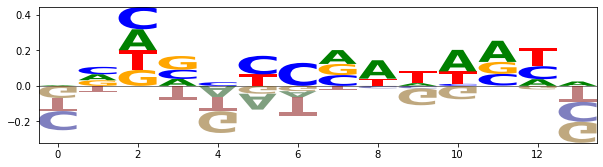

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


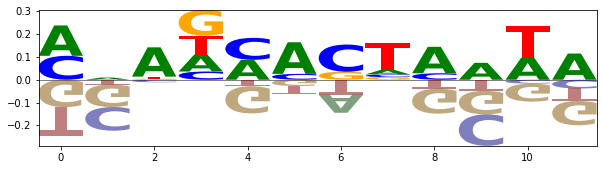

Epoch:  1, Loss: 0.523
Epoch: 11, Loss: 0.520
Epoch: 21, Loss: 0.520
Epoch: 31, Loss: 0.520
Epoch: 41, Loss: 0.520
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


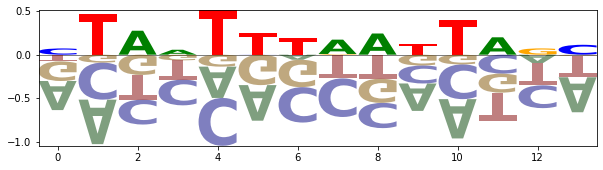

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


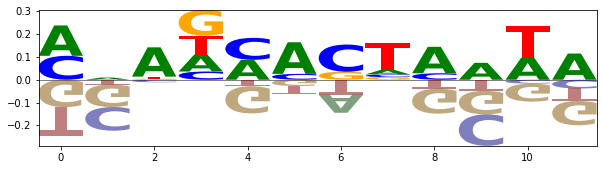

Parameter containing:
tensor([[ 0.0389],
        [ 2.6673],
        [ 1.8425],
        [-0.2215],
        [-4.3056]], requires_grad=True)
Epoch:  1, Loss: 0.517
Epoch: 11, Loss: 0.516
Epoch: 21, Loss: 0.515
Epoch: 31, Loss: 0.515
Epoch: 41, Loss: 0.515
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


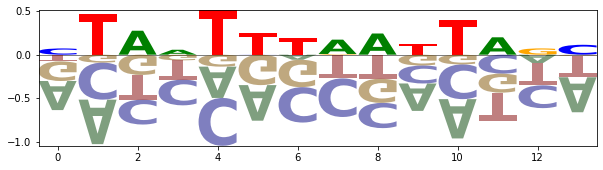

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


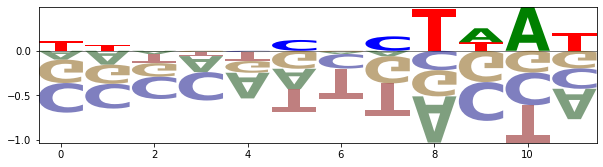

Parameter containing:
tensor([[-0.0551],
        [ 1.6301],
        [ 1.6441],
        [ 0.1916],
        [-3.4220]], requires_grad=True)


In [37]:
model = mb.models.DinucSelex(use_dinuc=False, kernels=[0, 14, 12], n_rounds=4).to(device) #, n_rounds=n_rounds)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()

mb.pl.conv_mono(model)
print(model.log_eta.weight)

update_grad(model, 0, True)
update_grad(model, 1, False)
update_grad(model, 2, False)
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=200, early_stopping=20, log_each=10)

mb.pl.conv_mono(model)

update_grad(model, 0, False)
update_grad(model, 1, True)
update_grad(model, 2, False)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=200, early_stopping=20, log_each=10)

mb.pl.conv_mono(model)
print(model.log_eta.weight)

update_grad(model, 0, False)
update_grad(model, 1, False)
update_grad(model, 2, True)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=200, early_stopping=20, log_each=10)

mb.pl.conv_mono(model)
print(model.log_eta.weight)

ETS1 and ELF2 combined

In [4]:
data['cycle'] = data['cycle'].astype(int)

In [8]:
data[(data['tf.name'] == 'ETS1') | (data['tf.name'] == 'ELF2')].sort_values('library')

,filename,library,batch,cycle,tf.name,accession
242,ELF2_eDBD_3_KAN_TAGGAG40NAGT.fastq.gz,TAGGAG40NAGT,eDBD,3,ELF2,PRJEB9797
250,ELF2_eDBD_1_KAN_TAGGAG40NAGT.fastq.gz,TAGGAG40NAGT,eDBD,1,ELF2,PRJEB9797
95,ELF2_eDBD_2_KAN_TAGGAG40NAGT.fastq.gz,TAGGAG40NAGT,eDBD,2,ELF2,PRJEB9797
199,ELF2_eDBD_4_KAN_TAGGAG40NAGT.fastq.gz,TAGGAG40NAGT,eDBD,4,ELF2,PRJEB9797
216,ELF2_eDBD_1_KR_TGAAAT40NCAA.fastq.gz,TGAAAT40NCAA,eDBD,1,ELF2,PRJEB9797
155,ELF2_eDBD_3_KR_TGAAAT40NCAA.fastq.gz,TGAAAT40NCAA,eDBD,3,ELF2,PRJEB9797
124,ELF2_eDBD_4_KR_TGAAAT40NCAA.fastq.gz,TGAAAT40NCAA,eDBD,4,ELF2,PRJEB9797
217,ELF2_eDBD_2_KR_TGAAAT40NCAA.fastq.gz,TGAAAT40NCAA,eDBD,2,ELF2,PRJEB9797
147,ELF2_FL_2_KX_TGCTTC40NTTA.fastq.gz,TGCTTC40NTTA,FL,2,ELF2,PRJEB9797
111,ELF2_FL_4_KX_TGCTTC40NTTA.fastq.gz,TGCTTC40NTTA,FL,4,ELF2,PRJEB9797


In [59]:
data[(data['library'] == 'TGTAAA20NGA') & (data['filename'] != 'ZeroCycle_TGTAAA20NGA_0_0.fastq.gz')]

,filename,library,batch,cycle,tf.name,accession
23,ETS1_TGTAAA20NGA_AF_1.fastq.gz,TGTAAA20NGA,AF,1,ETS1,PRJEB3289
33,ETS1_TGTAAA20NGA_AF_3.fastq.gz,TGTAAA20NGA,AF,3,ETS1,PRJEB3289
37,ETS1_TGTAAA20NGA_AF_4.fastq.gz,TGTAAA20NGA,AF,4,ETS1,PRJEB3289
55,ETS1_TGTAAA20NGA_AF_2.fastq.gz,TGTAAA20NGA,AF,2,ETS1,PRJEB3289
75,ZeroCycle_ES0_TGTAAA20NGA_0.txt.gz,TGTAAA20NGA,ES0,0,ZEROCYCLE,PRJEB14744


In [5]:
tf_names = ['ETS1', 'ELF2']
libraries = ['TGTAAA20NGA', 'TAGGAG40NAGT']
count_tables = []

for tf, lib in zip(tf_names, libraries):
    print('loading', tf, ':', lib)
    grp = data[data['library'] == lib]

    data_sel_tf = grp[(grp['tf.name'] == tf)]
    data_sel_zero = grp[(grp['cycle'] == 0) & grp['library'].isin(set(grp[grp['tf.name'] == tf]['library']))]  # & grp['accession'].isin(set(grp[grp['tf.name'] == tf]['accession']))]

    print(data_sel_tf.shape[0], data_sel_zero.shape[0])
    if data_sel_tf.shape[0] == 0 or data_sel_zero.shape[0] == 0:
        continue

    reads_tf = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_tf)
    reads_zero = mb.bindome.datasets.SELEX.load_read_counts(data=data_sel_zero, library=lib)

    print(reads_tf.keys(), reads_zero.keys())

    for k_r0 in reads_zero:
        if 'ZeroCycle_TGTAAA20NGA_0_0' in k_r0:
            continue

        n_rounds = len(reads_tf.keys())
        print(n_rounds)

        # combine all the positive round data
        df2 = []
        for k in reads_tf.keys():
            df = reads_tf[k]
            df['k'] = k
            df2.append(df)
        df = pd.concat(df2)
        df = df.pivot('seq', 'k', 'counts').fillna(0).reset_index()

        next_data = reads_zero[k_r0].merge(df, on='seq', how='outer').fillna(0) # .astype(int)

        new_cols = ['seq', k_r0] + list(df.columns[1:])
        next_data.columns = new_cols
        for i, k in enumerate(next_data.columns[1:]):
            next_data[k] = next_data[k].astype(int)
            next_data[i] = next_data[k].astype(int)

        next_data['sum'] = next_data[[i for i in range(0, n_rounds + 1)]].sum(axis=1).values
        next_data = next_data.sort_values('sum', ascending=False)

        print('sampling from top n reds in round 1 ...')
        print(next_data.shape)
        next_data = next_data.head(100000).reset_index(drop=True)
        print(next_data.shape)

        count_tables.append(next_data)

loading ETS1 : TGTAAA20NGA
4 2
# uniq reads/total counts 178944/180855
# uniq reads/total counts 172559/230033
# uniq reads/total counts 42327/94179
# uniq reads/total counts 174479/179246
# uniq reads/total counts 10386/10431
# uniq reads/total counts 228351/228457
dict_keys(['ETS1_TGTAAA20NGA_AF_1', 'ETS1_TGTAAA20NGA_AF_3', 'ETS1_TGTAAA20NGA_AF_4', 'ETS1_TGTAAA20NGA_AF_2']) dict_keys(['ZeroCycle_TGTAAA20NGA_0_0', 'ZeroCycle_ES0_TGTAAA20NGA_0'])
4
sampling from top n reds in round 1 ...
(772868, 12)
(100000, 12)
loading ELF2 : TAGGAG40NAGT
4 1
# uniq reads/total counts 412926/417688
# uniq reads/total counts 260065/281918
# uniq reads/total counts 351193/358062
# uniq reads/total counts 427930/432398
# uniq reads/total counts 183613/184150
dict_keys(['ELF2_eDBD_2_KAN_TAGGAG40NAGT', 'ELF2_eDBD_4_KAN_TAGGAG40NAGT', 'ELF2_eDBD_3_KAN_TAGGAG40NAGT', 'ELF2_eDBD_1_KAN_TAGGAG40NAGT']) dict_keys(['ZeroCycle_TAGGAG40NAGT_0_0'])
4
sampling from top n reds in round 1 ...
(1604500, 12)
(100000, 12

In [6]:
next_data = pd.concat([count_tables[0][['seq', 0, 1, 2, 3, 4]], count_tables[1][['seq', 0, 1, 2, 3, 4]]]).reset_index(drop=True)

In [19]:
next_data

,seq,0,1,2,3,4
0,CCGGAAGTACTTCCGCCCAT,0,0,8,1110,4394
1,CGGAAGCACTTCCGGTGTGA,0,0,12,1288,3820
2,CCGGATGCGCTTCCGCCCAC,0,0,7,1014,2629
3,CCGGATACGCATCCGGCCAT,0,0,13,794,1869
4,CCGGAAGTGTATCCTGCCTT,0,0,11,808,1612
...,...,...,...,...,...,...
199995,GATGGCGGGTATGGTAAAAAGCGCACTAGGGTACCTTCGT,0,1,0,0,0
199996,GATGGCGGGGTTAAGTCTATGCTGAGGTGTTAAGGACGAC,0,1,0,0,0
199997,GATGGCGGGGTGTGTGGATTTGTTCTATGGCGTGAAGCGG,0,0,1,0,0
199998,GATGGCGGGGGTGTGATGGTGACCAGAGTAGATTGTTTGT,0,0,1,0,0


In [7]:
set(next_data['seq'].str.len())

{20, 40}

In [8]:
dataset = mb.datasets.SelexDataset(next_data, max_length=40, n_rounds=4)
train = tdata.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
train_test = tdata.DataLoader(dataset=dataset, batch_size=1, shuffle=False)

Training without freezing

In [26]:
model = mb.models.DinucSelex(use_dinuc=False, kernels=[0, 14, 12], n_rounds=4).to(device)
l2 = []
optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = topti.LBFGS(model.parameters())
criterion = mb.tl.PoissonLoss()

In [30]:
l2 += mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=10, log_each=1)

Epoch:  1, Loss: 0.225
Epoch:  2, Loss: -0.138
Epoch:  3, Loss: -0.144
Epoch:  4, Loss: -0.149
Epoch:  5, Loss: -0.154
Epoch:  6, Loss: -0.157
Epoch:  7, Loss: -0.166
Epoch:  8, Loss: -0.188
Epoch:  9, Loss: -0.213
Epoch: 10, Loss: -0.222


0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


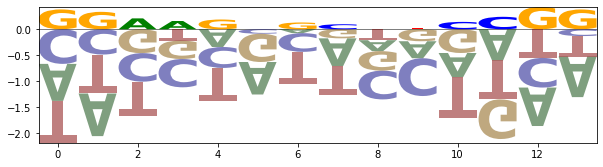

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


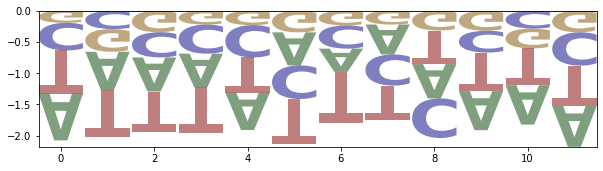

In [33]:
mb.pl.conv_mono(model)

Training with layerwise freezing

0 None
1 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


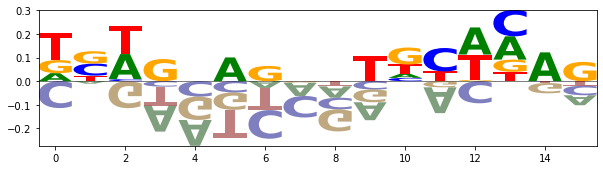

2 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


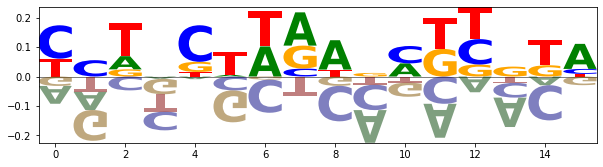

Epoch:  1, Loss: 0.780
Epoch:  2, Loss: 0.229
Epoch:  3, Loss: 0.223
Epoch:  4, Loss: 0.224
Epoch:  5, Loss: 0.223
Epoch:  6, Loss: 0.224
Epoch:  7, Loss: 0.223
Epoch:  8, Loss: 0.222
Epoch:  9, Loss: 0.223
Epoch: 10, Loss: 0.221
Epoch: 11, Loss: 0.222
Epoch: 12, Loss: 0.222
0 None
1 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


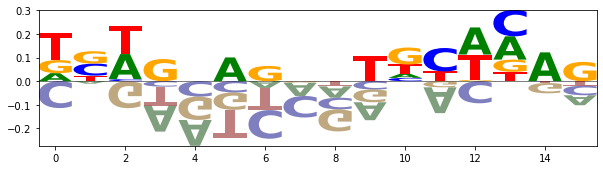

2 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


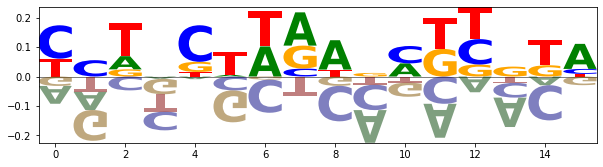

Epoch:  1, Loss: 0.213
Epoch:  2, Loss: 0.174
Epoch:  3, Loss: 0.165
Epoch:  4, Loss: 0.163
Epoch:  5, Loss: 0.163
Epoch:  6, Loss: 0.163
0 None
1 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


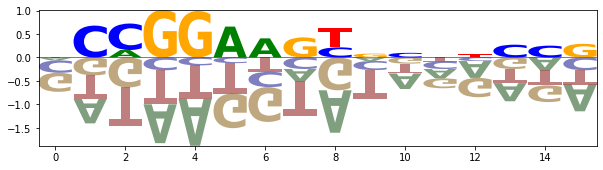

2 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


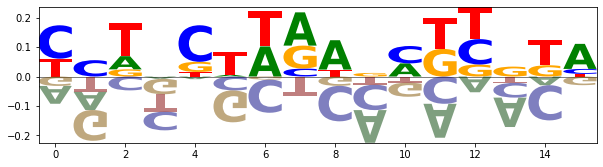

Parameter containing:
tensor([[ 1.2861],
        [ 5.9555],
        [ 2.0017],
        [-2.0734],
        [-6.5156]], requires_grad=True)
Epoch:  1, Loss: 0.154
Epoch:  2, Loss: 0.154
Epoch:  3, Loss: 0.152
Epoch:  4, Loss: 0.152
Epoch:  5, Loss: 0.152
Epoch:  6, Loss: 0.152
0 None
1 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


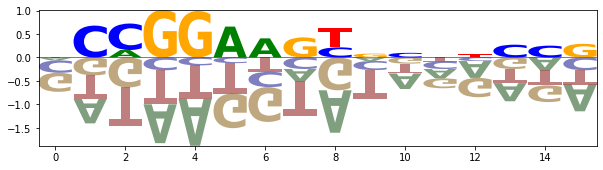

2 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


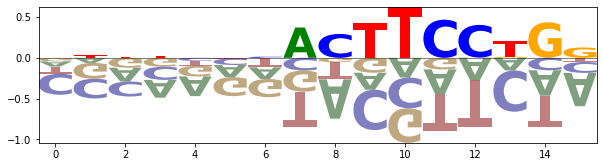

In [11]:
model = mb.models.DinucSelex(use_dinuc=False, kernels=[0, 16, 16], n_rounds=4).to(device) #, n_rounds=n_rounds)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()

mb.pl.conv_mono(model)

update_grad(model, 0, True)
update_grad(model, 1, False)
update_grad(model, 2, False)
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=20, early_stopping=2, log_each=1)

mb.pl.conv_mono(model)

update_grad(model, 0, False)
update_grad(model, 1, True)
update_grad(model, 2, False)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=20, early_stopping=2, log_each=1)

mb.pl.conv_mono(model)

update_grad(model, 0, False)
update_grad(model, 1, False)
update_grad(model, 2, True)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=20, early_stopping=2, log_each=1)

mb.pl.conv_mono(model)

0 None
1 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


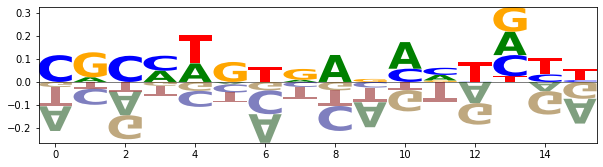

2 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


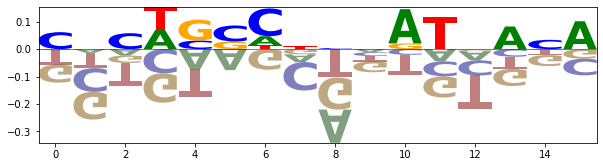

Epoch:  1, Loss: 0.742
Epoch:  2, Loss: 0.223
Epoch:  3, Loss: 0.219
Epoch:  4, Loss: 0.220
Epoch:  5, Loss: 0.218
Epoch:  6, Loss: 0.218
Epoch:  7, Loss: 0.219
0 None
1 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


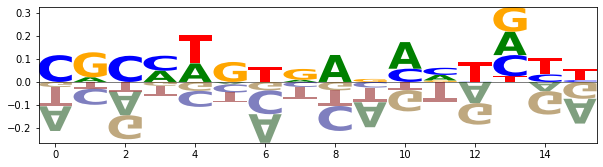

2 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


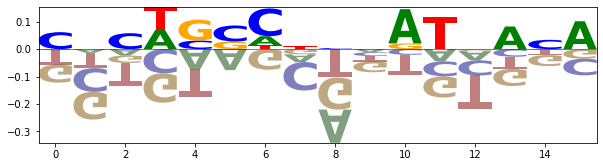

Epoch:  1, Loss: 0.213
Epoch:  2, Loss: 0.187
Epoch:  3, Loss: 0.168
Epoch:  4, Loss: 0.164
Epoch:  5, Loss: 0.163
Epoch:  6, Loss: 0.164
Epoch:  7, Loss: 0.164
0 None
1 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


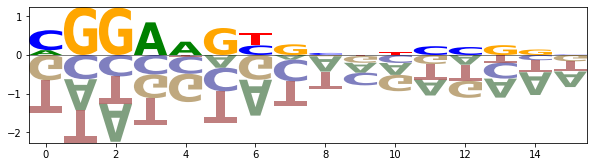

2 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


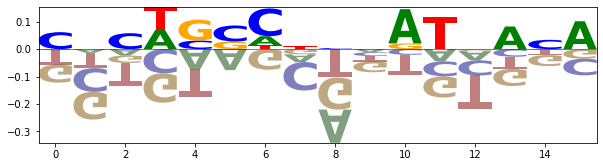

Epoch:  1, Loss: 0.146
Epoch:  2, Loss: 0.144
Epoch:  3, Loss: 0.141
Epoch:  4, Loss: 0.140
Epoch:  5, Loss: 0.138
Epoch:  6, Loss: 0.139
Epoch:  7, Loss: 0.139
0 None
1 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


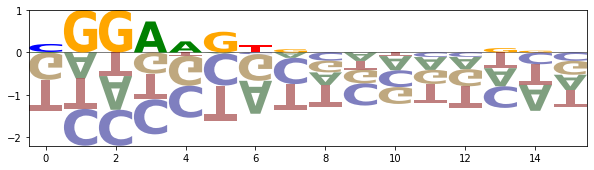

2 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


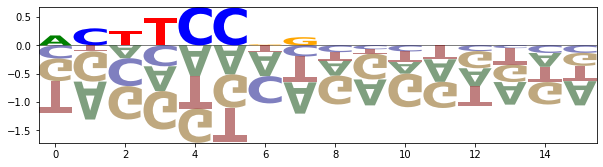

In [12]:
model = mb.models.DinucSelex(use_dinuc=False, kernels=[0, 16, 16], n_rounds=4).to(device) #, n_rounds=n_rounds)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()

mb.pl.conv_mono(model)

update_grad(model, 0, True)
update_grad(model, 1, False)
update_grad(model, 2, False)
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=20, early_stopping=2, log_each=1)

mb.pl.conv_mono(model)

# update_grad(model, 0, False)
update_grad(model, 1, True)
# update_grad(model, 2, False)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=20, early_stopping=2, log_each=1)

mb.pl.conv_mono(model)

# update_grad(model, 0, False)
# update_grad(model, 1, False)
update_grad(model, 2, True)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=20, early_stopping=2, log_each=1)

mb.pl.conv_mono(model)

0 None
1 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


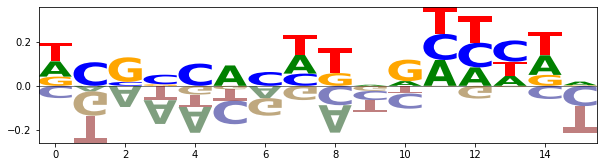

2 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


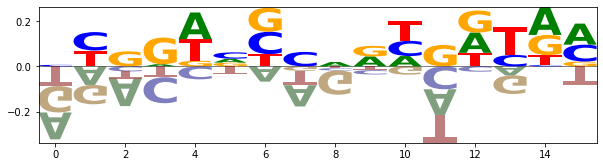

0 None
1 Conv2d(1, 1, kernel_size=(16, 16), stride=(1, 1), bias=False)


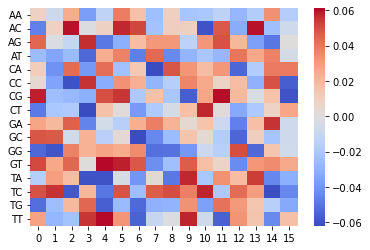

2 Conv2d(1, 1, kernel_size=(16, 16), stride=(1, 1), bias=False)


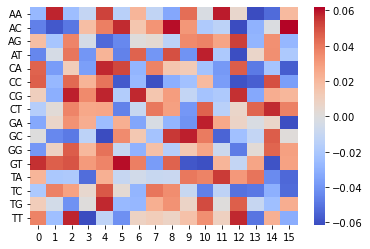

Epoch:  1, Loss: 1.018
Epoch:  2, Loss: 0.248
Epoch:  3, Loss: 0.222
Epoch:  4, Loss: 0.223
Epoch:  5, Loss: 0.222
Epoch:  6, Loss: 0.222
Epoch:  7, Loss: 0.221
Epoch:  8, Loss: 0.153
Epoch:  9, Loss: 0.223
Epoch: 10, Loss: 0.221
0 None
1 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


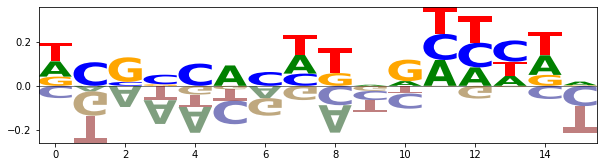

2 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


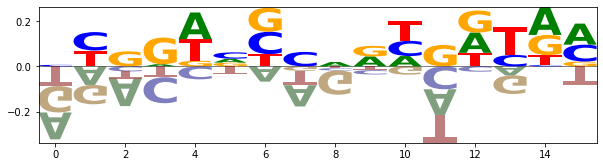

0 None
1 Conv2d(1, 1, kernel_size=(16, 16), stride=(1, 1), bias=False)


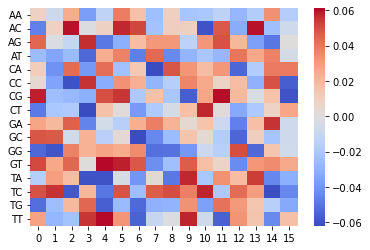

2 Conv2d(1, 1, kernel_size=(16, 16), stride=(1, 1), bias=False)


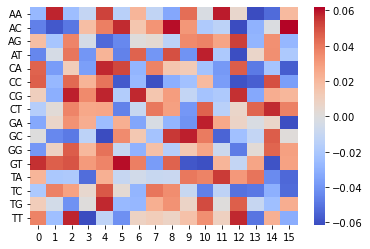

Epoch:  1, Loss: 0.184
Epoch:  2, Loss: 0.159
Epoch:  3, Loss: 0.158
Epoch:  4, Loss: 0.157
Epoch:  5, Loss: 0.157
Epoch:  6, Loss: 0.156
Epoch:  7, Loss: 0.157
Epoch:  8, Loss: 0.157
0 None
1 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


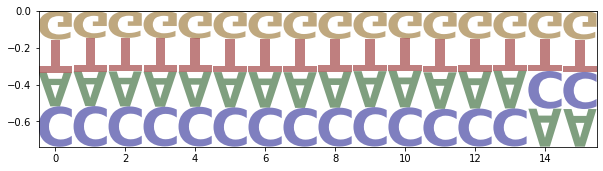

2 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


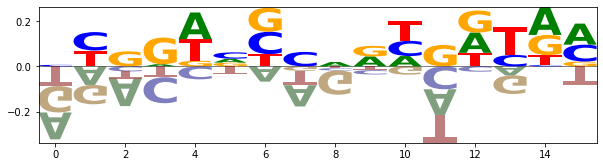

0 None
1 Conv2d(1, 1, kernel_size=(16, 16), stride=(1, 1), bias=False)


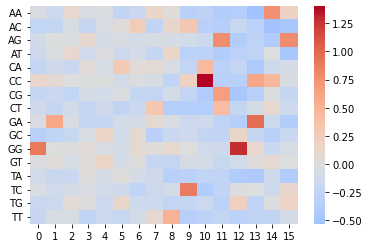

2 Conv2d(1, 1, kernel_size=(16, 16), stride=(1, 1), bias=False)


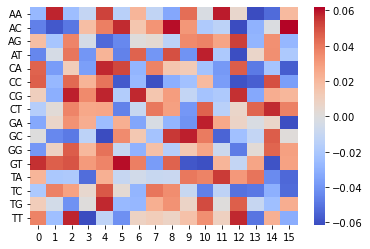

Epoch:  1, Loss: 0.140
Epoch:  2, Loss: 0.135
Epoch:  3, Loss: 0.133
Epoch:  4, Loss: 0.132
Epoch:  5, Loss: 0.131
Epoch:  6, Loss: 0.132
Epoch:  7, Loss: 0.131
0 None
1 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


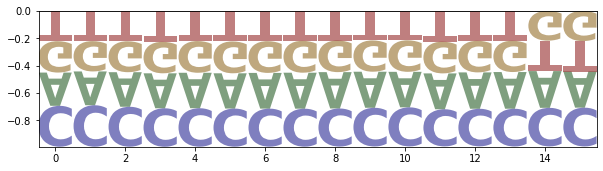

2 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


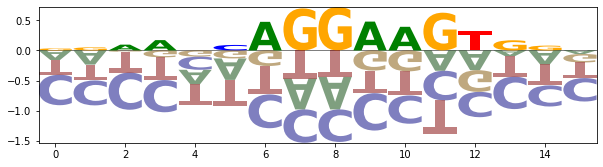

0 None
1 Conv2d(1, 1, kernel_size=(16, 16), stride=(1, 1), bias=False)


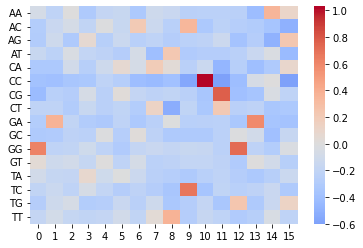

2 Conv2d(1, 1, kernel_size=(16, 16), stride=(1, 1), bias=False)


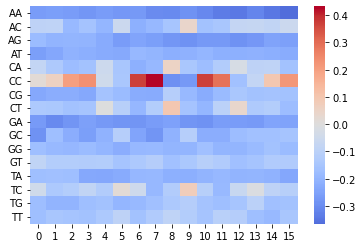

In [15]:
model = mb.models.DinucSelex(use_dinuc=True, kernels=[0, 16, 16], n_rounds=4).to(device) #, n_rounds=n_rounds)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()

mb.pl.conv_mono(model)
mb.pl.conv_di(model)

update_grad(model, 0, True)
update_grad(model, 1, False)
update_grad(model, 2, False)
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=20, early_stopping=2, log_each=1)

mb.pl.conv_mono(model)
mb.pl.conv_di(model)

# update_grad(model, 0, False)
update_grad(model, 1, True)
# update_grad(model, 2, False)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=20, early_stopping=2, log_each=1)

mb.pl.conv_mono(model)
mb.pl.conv_di(model)

# update_grad(model, 0, False)
# update_grad(model, 1, False)
update_grad(model, 2, True)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=20, early_stopping=2, log_each=1)

mb.pl.conv_mono(model)
mb.pl.conv_di(model)

0 None
1 Conv2d(1, 1, kernel_size=(4, 8), stride=(1, 1), bias=False)


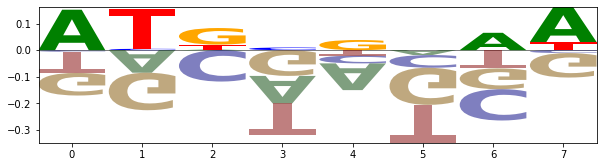

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


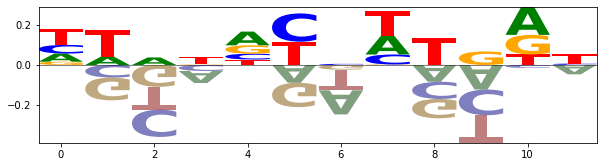

3 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


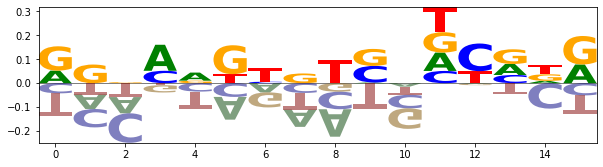

Epoch:  1, Loss: 0.925
Epoch:  2, Loss: 0.238
Epoch:  3, Loss: 0.223
Epoch:  4, Loss: 0.222
Epoch:  5, Loss: 0.222
Epoch:  6, Loss: 0.222
Epoch:  7, Loss: 0.222
Epoch:  8, Loss: 0.221
Epoch:  9, Loss: 0.222
Epoch: 10, Loss: 0.221
Epoch: 11, Loss: 0.221
Epoch: 12, Loss: 0.221
Epoch: 13, Loss: 0.221
Epoch: 14, Loss: 0.220
Epoch: 15, Loss: 0.221
Epoch: 16, Loss: 0.221
0 None
1 Conv2d(1, 1, kernel_size=(4, 8), stride=(1, 1), bias=False)


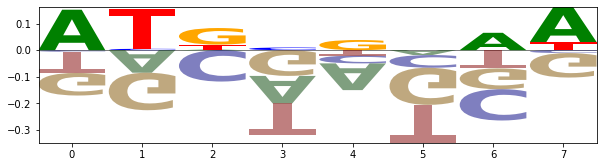

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


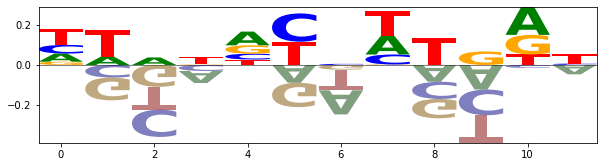

3 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


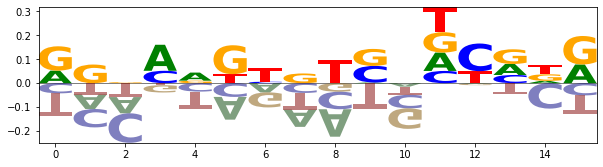

Epoch:  1, Loss: 0.216
Epoch:  2, Loss: 0.216
Epoch:  3, Loss: 0.217
0 None
1 Conv2d(1, 1, kernel_size=(4, 8), stride=(1, 1), bias=False)


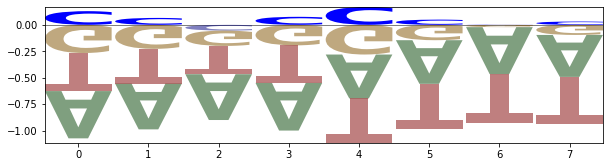

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


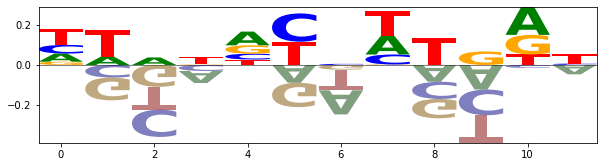

3 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


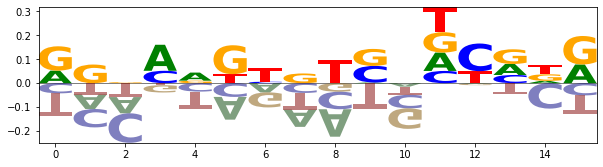

Epoch:  1, Loss: 0.210
Epoch:  2, Loss: 0.208
Epoch:  3, Loss: 0.202
Epoch:  4, Loss: 0.183
Epoch:  5, Loss: 0.177
Epoch:  6, Loss: 0.176
Epoch:  7, Loss: 0.174
Epoch:  8, Loss: 0.174
Epoch:  9, Loss: 0.172
Epoch: 10, Loss: 0.168
Epoch: 11, Loss: 0.167
Epoch: 12, Loss: 0.165
Epoch: 13, Loss: 0.166
Epoch: 14, Loss: 0.164
Epoch: 15, Loss: 0.165
Epoch: 16, Loss: 0.165
0 None
1 Conv2d(1, 1, kernel_size=(4, 8), stride=(1, 1), bias=False)


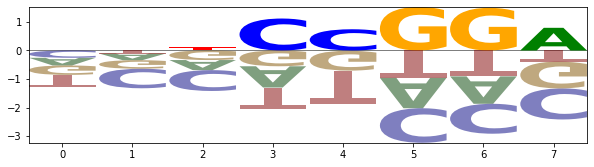

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


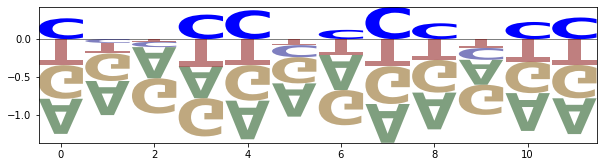

3 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


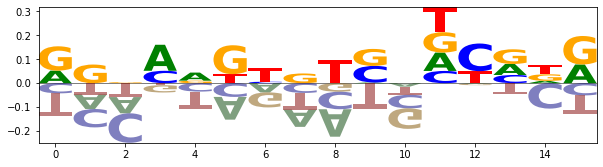

Epoch:  1, Loss: 0.159
Epoch:  2, Loss: 0.157
Epoch:  3, Loss: 0.150
Epoch:  4, Loss: 0.143
Epoch:  5, Loss: 0.143
Epoch:  6, Loss: 0.143
Epoch:  7, Loss: 0.144
Epoch:  8, Loss: 0.142
Epoch:  9, Loss: 0.144
Epoch: 10, Loss: 0.144
0 None
1 Conv2d(1, 1, kernel_size=(4, 8), stride=(1, 1), bias=False)


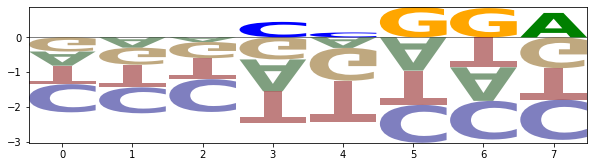

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


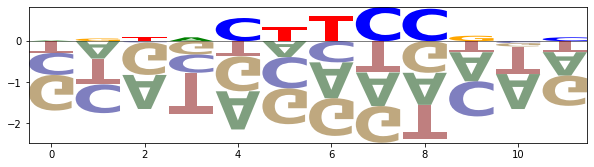

3 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


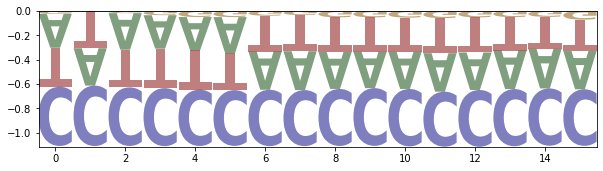

In [16]:
model = mb.models.DinucSelex(use_dinuc=False, kernels=[0, 8, 12, 16], n_rounds=4).to(device) #, n_rounds=n_rounds)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()

mb.pl.conv_mono(model)

update_grad(model, 0, True)
update_grad(model, 1, False)
update_grad(model, 2, False)
update_grad(model, 3, False)
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=20, early_stopping=2, log_each=1)

mb.pl.conv_mono(model)

# update_grad(model, 0, False)
update_grad(model, 1, True)
# update_grad(model, 2, False)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=20, early_stopping=2, log_each=1)

mb.pl.conv_mono(model)

# update_grad(model, 0, False)
# update_grad(model, 1, False)
update_grad(model, 2, True)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=20, early_stopping=2, log_each=1)

mb.pl.conv_mono(model)

# update_grad(model, 0, False)
# update_grad(model, 1, False)
# update_grad(model, 2, True)
update_grad(model, 3, True)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=20, early_stopping=2, log_each=1)

mb.pl.conv_mono(model)

0 None
1 Conv2d(1, 1, kernel_size=(4, 1), stride=(1, 1), bias=False)


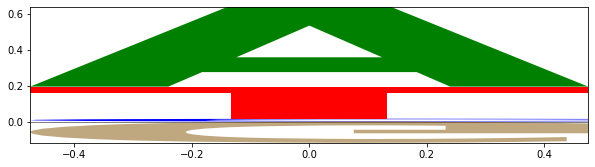

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


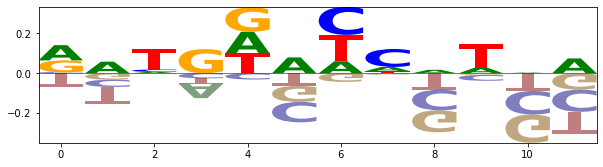

3 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


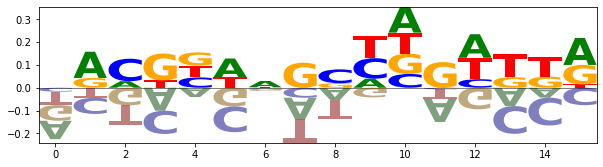

Epoch:  1, Loss: 0.853
Epoch:  2, Loss: 0.231
Epoch:  3, Loss: 0.223
Epoch:  4, Loss: 0.223
Epoch:  5, Loss: 0.222
Epoch:  6, Loss: 0.222
Epoch:  7, Loss: 0.222
Epoch:  8, Loss: 0.222
Epoch:  9, Loss: 0.221
Epoch: 10, Loss: 0.221
Epoch: 11, Loss: 0.221
Epoch: 12, Loss: 0.222
Epoch: 13, Loss: 0.221
Epoch: 14, Loss: 0.219
Epoch: 15, Loss: 0.221
Epoch: 16, Loss: 0.220
0 None
1 Conv2d(1, 1, kernel_size=(4, 1), stride=(1, 1), bias=False)


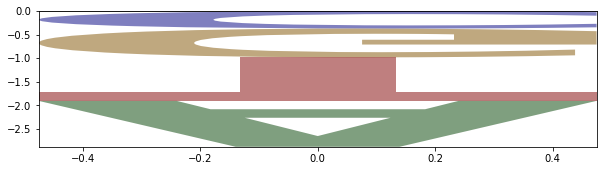

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


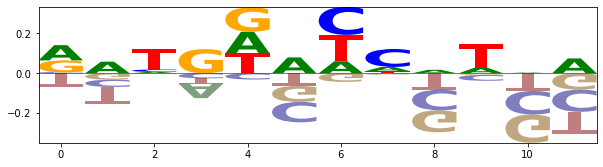

3 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


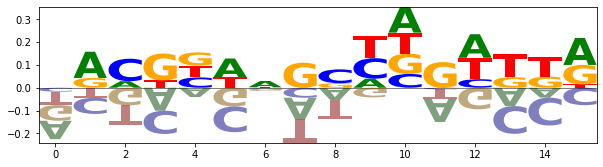

Epoch:  1, Loss: 0.216
Epoch:  2, Loss: 0.213
Epoch:  3, Loss: 0.213
Epoch:  4, Loss: 0.214
Epoch:  5, Loss: 0.212
Epoch:  6, Loss: 0.184
Epoch:  7, Loss: 0.176
Epoch:  8, Loss: 0.174
Epoch:  9, Loss: 0.173
Epoch: 10, Loss: 0.174
Epoch: 11, Loss: 0.173
0 None
1 Conv2d(1, 1, kernel_size=(4, 1), stride=(1, 1), bias=False)


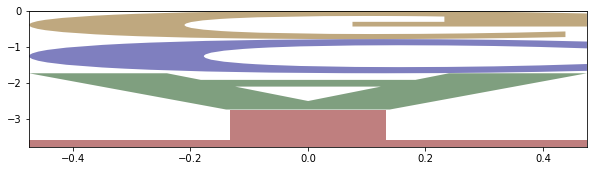

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


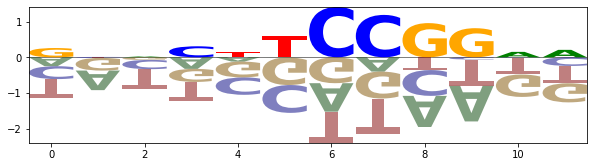

3 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


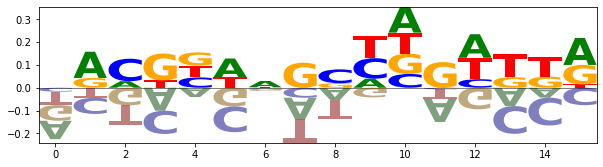

Epoch:  1, Loss: 0.163
Epoch:  2, Loss: 0.153
Epoch:  3, Loss: 0.139
Epoch:  4, Loss: 0.138
Epoch:  5, Loss: 0.137
Epoch:  6, Loss: 0.139
Epoch:  7, Loss: 0.138
0 None
1 Conv2d(1, 1, kernel_size=(4, 1), stride=(1, 1), bias=False)


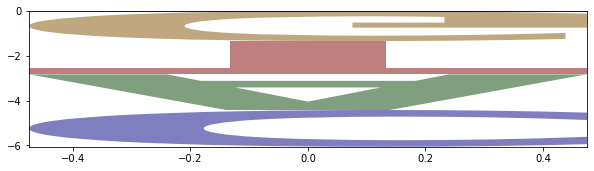

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


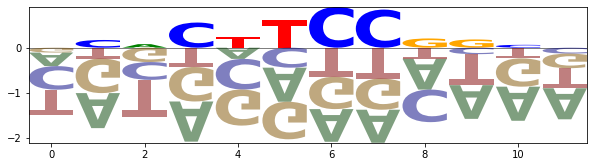

3 Conv2d(1, 1, kernel_size=(4, 16), stride=(1, 1), bias=False)


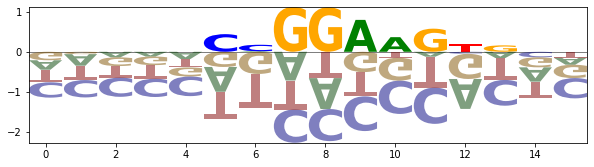

In [17]:
model = mb.models.DinucSelex(use_dinuc=False, kernels=[0, 1, 12, 16], n_rounds=4).to(device) #, n_rounds=n_rounds)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()

mb.pl.conv_mono(model)

update_grad(model, 0, True)
update_grad(model, 1, True)
update_grad(model, 2, False)
update_grad(model, 3, False)
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=20, early_stopping=2, log_each=1)

mb.pl.conv_mono(model)

# update_grad(model, 0, False)
# update_grad(model, 1, False)
update_grad(model, 2, True)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=20, early_stopping=2, log_each=1)

mb.pl.conv_mono(model)

# update_grad(model, 0, False)
# update_grad(model, 1, False)
# update_grad(model, 2, True)
update_grad(model, 3, True)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=20, early_stopping=2, log_each=1)

mb.pl.conv_mono(model)